In [6]:
%load_ext autoreload
%autoreload 2

from itertools import product
import os

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import cv2

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

from neuode.interface.common import *
from neuode.interface.struct import *
from neuode.util.logging import logger
import neuode.util.logging as logging
import neuode.function.linear as linear
import neuode.function.conv as conv
import neuode.ode.odeblock as odeblock
import neuode.model.vae as model_vae

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
print('blah')

blah


In [8]:
DPATH = '~/Documents/dataset'
BATCH_TRAIN_SIZE = 64
DIGIT = 0
C_AUGMENT = 0

class MNISTDigit(torch.utils.data.Dataset):
    
    def __init__(self, mnist, digit, augment):
        self.mnist = mnist
        self.digit = digit
        self.augment = augment
        
        self.idxs = []
        for i, (_, label) in enumerate(self.mnist):
            if label == self.digit:
                self.idxs.append(i)
                
    def __len__(self):
        return len(self.idxs)
        
    def __getitem__(self, idx):
        img, label = self.mnist[self.idxs[idx]]
        return self.augment_image(img), label
    
#     def __iter__(self):
#         for img, label in self.mnist:
#             if label == self.digit:
#                 yield self.augment_image(img), label

    def augment_image(self, img):
        channels, height, width = img.shape
        img_aug = torch.zeros(self.augment, height, width)
        return torch.cat([img, img_aug], 0)
        

mnist = torchvision.datasets.MNIST(DPATH, train=True, download=True,
        transform=torchvision.transforms.Compose([
            torchvision.transforms.Resize((32, 32)),
            torchvision.transforms.ToTensor(),
            # torchvision.transforms.Normalize((0.1307,), (0.3081,))
    ]))
dmnist = []
for d in range(10):
    print('loading digit', d)
    dmnist.append(MNISTDigit(mnist, d, C_AUGMENT))

train_loader = torch.utils.data.DataLoader(dmnist[DIGIT], batch_size=BATCH_TRAIN_SIZE, shuffle=True)
mnist_loader = torch.utils.data.DataLoader(mnist, batch_size=BATCH_TRAIN_SIZE, shuffle=True)

loading digit 0
loading digit 1
loading digit 2
loading digit 3
loading digit 4
loading digit 5
loading digit 6
loading digit 7
loading digit 8
loading digit 9


Text(0.5, 1.0, 'digit= 0')

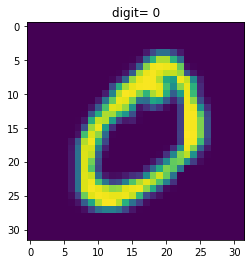

In [10]:
# principle digit (mean)
ideal_digit, label = dmnist[0][0]
plt.imshow(ideal_digit[0, ...])
plt.title('digit= %d'%label)

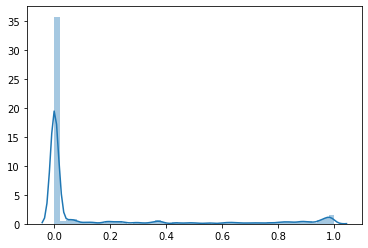

In [11]:
sns.distplot(ideal_digit.flatten())

In [68]:
# build model
cfn_specs = [
    ConvSpec(C_AUGMENT+1, C_AUGMENT+3, kernel_size=5, stride=1, padding=2, 
             act_fn=ActivationFn.RELU),
    ConvSpec(C_AUGMENT+3, C_AUGMENT+3, kernel_size=5, stride=1, padding=2, 
             act_fn=ActivationFn.RELU),
    ConvSpec(C_AUGMENT+3, C_AUGMENT+1, kernel_size=5, stride=1, padding=2,
             act_fn=ActivationFn.NONE),
]
ode_spec = ODEBlockSpec(use_adjoint=True)
cfn = conv.FullConvDMap(cfn_specs)
net = odeblock.ODEBlock(cfn, ode_spec)

In [39]:
# build time-dependent model
cfn_specs_t = [
    ConvSpec(C_AUGMENT+1, C_AUGMENT+3, kernel_size=5, stride=1, padding=2, 
             act_fn=ActivationFn.RELU, use_time=True),
    ConvSpec(C_AUGMENT+3, C_AUGMENT+3, kernel_size=5, stride=1, padding=2, 
             act_fn=ActivationFn.RELU, use_time=True),
    ConvSpec(C_AUGMENT+3, C_AUGMENT+1, kernel_size=5, stride=1, padding=2,
             act_fn=ActivationFn.NONE, use_time=True),
]
ode_spec_t = ODEBlockSpec(use_adjoint=True)
cfn_t = conv.FullConvDMap(cfn_specs_t)
net_t = odeblock.ODEBlock(cfn_t, ode_spec_t)

In [75]:
# train
def train(net):
    lr, momentum = 0.01, 0.9
    net.train()
    for epoch in range(20):
        criterion = nn.MSELoss()
        optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum)
        total = len(train_loader)
        for batch_idx, (data, _) in enumerate(train_loader):
            optimizer.zero_grad()
            pred = net(data)
            loss = criterion(pred[:, 0, ...], ideal_digit.repeat(len(data), 1, 1, 1)[:, 0, ...])
            loss.backward()
            optimizer.step()
            if batch_idx%1 == 0 or batch_idx == total-1:
                print('Epoch %3d [%4d/%4d (%2d%%)]: loss= %f'%(
                    epoch, batch_idx, total, int(100 * batch_idx / total), loss.item()))
            if batch_idx%5 == 0:
                plot_check(net, 10)
                plt.show()

Epoch   0 [   0/  93 ( 0%)]: loss= 0.354913


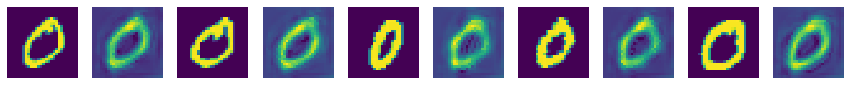

Epoch   0 [   1/  93 ( 1%)]: loss= 0.365679
Epoch   0 [   2/  93 ( 2%)]: loss= 0.341963
Epoch   0 [   3/  93 ( 3%)]: loss= 0.349500
Epoch   0 [   4/  93 ( 4%)]: loss= 0.373085
Epoch   0 [   5/  93 ( 5%)]: loss= 0.346547


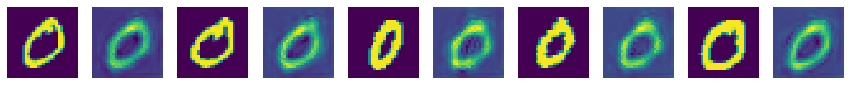

Epoch   0 [   6/  93 ( 6%)]: loss= 0.341260
Epoch   0 [   7/  93 ( 7%)]: loss= 0.348714
Epoch   0 [   8/  93 ( 8%)]: loss= 0.335692
Epoch   0 [   9/  93 ( 9%)]: loss= 0.345897
Epoch   0 [  10/  93 (10%)]: loss= 0.354799


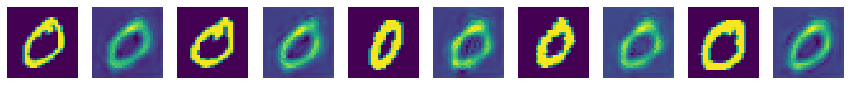

Epoch   0 [  11/  93 (11%)]: loss= 0.362120
Epoch   0 [  12/  93 (12%)]: loss= 0.326033
Epoch   0 [  13/  93 (13%)]: loss= 0.342977
Epoch   0 [  14/  93 (15%)]: loss= 0.401823
Epoch   0 [  15/  93 (16%)]: loss= 0.394216


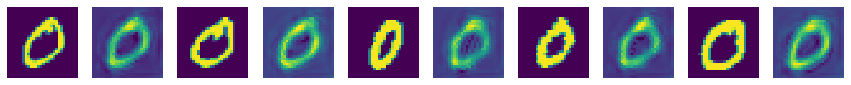

Epoch   0 [  16/  93 (17%)]: loss= 0.334536
Epoch   0 [  17/  93 (18%)]: loss= 0.443955
Epoch   0 [  18/  93 (19%)]: loss= 0.367023
Epoch   0 [  19/  93 (20%)]: loss= 0.403810
Epoch   0 [  20/  93 (21%)]: loss= 0.334270


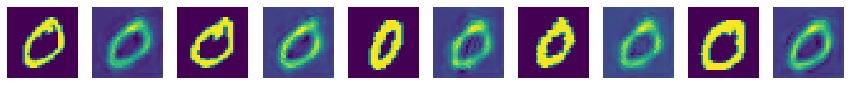

Epoch   0 [  21/  93 (22%)]: loss= 0.379021
Epoch   0 [  22/  93 (23%)]: loss= 0.383704
Epoch   0 [  23/  93 (24%)]: loss= 0.393447
Epoch   0 [  24/  93 (25%)]: loss= 0.417514
Epoch   0 [  25/  93 (26%)]: loss= 0.353889


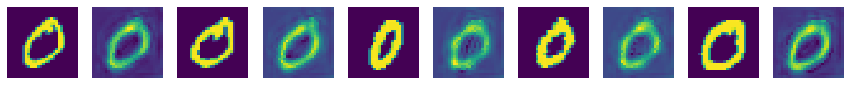

Epoch   0 [  26/  93 (27%)]: loss= 0.404253
Epoch   0 [  27/  93 (29%)]: loss= 0.353565
Epoch   0 [  28/  93 (30%)]: loss= 0.401143
Epoch   0 [  29/  93 (31%)]: loss= 0.314248
Epoch   0 [  30/  93 (32%)]: loss= 0.342581


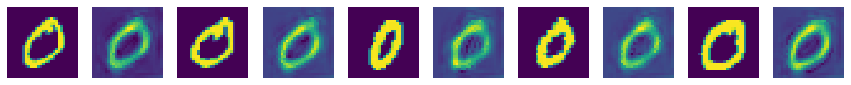

Epoch   0 [  31/  93 (33%)]: loss= 0.340053
Epoch   0 [  32/  93 (34%)]: loss= 0.332054
Epoch   0 [  33/  93 (35%)]: loss= 0.298541
Epoch   0 [  34/  93 (36%)]: loss= 0.313066
Epoch   0 [  35/  93 (37%)]: loss= 0.301374


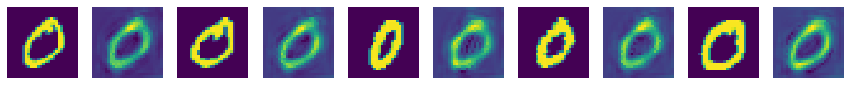

Epoch   0 [  36/  93 (38%)]: loss= 0.295603
Epoch   0 [  37/  93 (39%)]: loss= 0.308495
Epoch   0 [  38/  93 (40%)]: loss= 0.281424
Epoch   0 [  39/  93 (41%)]: loss= 0.290306
Epoch   0 [  40/  93 (43%)]: loss= 0.311463


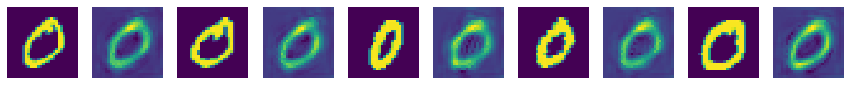

Epoch   0 [  41/  93 (44%)]: loss= 0.272256
Epoch   0 [  42/  93 (45%)]: loss= 0.262143
Epoch   0 [  43/  93 (46%)]: loss= 0.296436
Epoch   0 [  44/  93 (47%)]: loss= 0.295851
Epoch   0 [  45/  93 (48%)]: loss= 0.283974


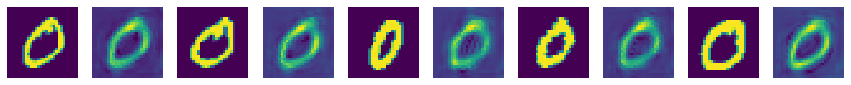

Epoch   0 [  46/  93 (49%)]: loss= 0.308395
Epoch   0 [  47/  93 (50%)]: loss= 0.363457
Epoch   0 [  48/  93 (51%)]: loss= 0.440012
Epoch   0 [  49/  93 (52%)]: loss= 0.334618
Epoch   0 [  50/  93 (53%)]: loss= 0.444102


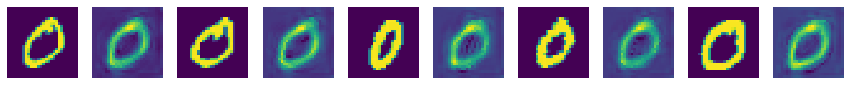

Epoch   0 [  51/  93 (54%)]: loss= 0.324293
Epoch   0 [  52/  93 (55%)]: loss= 0.396106
Epoch   0 [  53/  93 (56%)]: loss= 0.282061
Epoch   0 [  54/  93 (58%)]: loss= 0.444219
Epoch   0 [  55/  93 (59%)]: loss= 0.323379


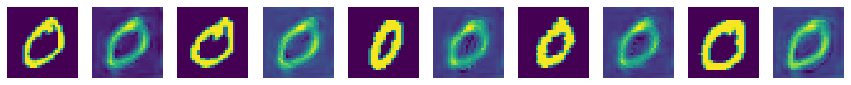

Epoch   0 [  56/  93 (60%)]: loss= 0.418298
Epoch   0 [  57/  93 (61%)]: loss= 0.366667
Epoch   0 [  58/  93 (62%)]: loss= 0.389963
Epoch   0 [  59/  93 (63%)]: loss= 0.390472
Epoch   0 [  60/  93 (64%)]: loss= 0.346289


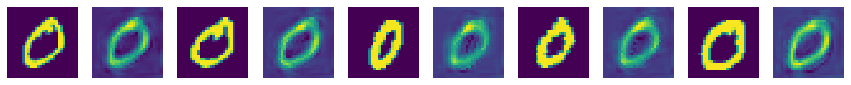

Epoch   0 [  61/  93 (65%)]: loss= 0.401607
Epoch   0 [  62/  93 (66%)]: loss= 0.351159
Epoch   0 [  63/  93 (67%)]: loss= 0.367452
Epoch   0 [  64/  93 (68%)]: loss= 0.356271
Epoch   0 [  65/  93 (69%)]: loss= 0.330641


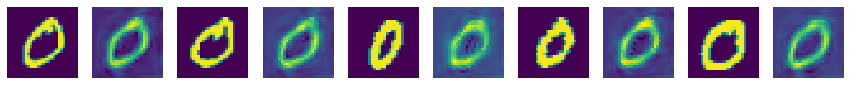

Epoch   0 [  66/  93 (70%)]: loss= 0.357136
Epoch   0 [  67/  93 (72%)]: loss= 0.309579
Epoch   0 [  68/  93 (73%)]: loss= 0.350494
Epoch   0 [  69/  93 (74%)]: loss= 0.314875
Epoch   0 [  70/  93 (75%)]: loss= 0.314042


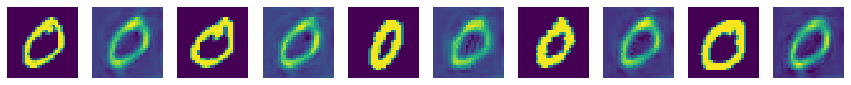

Epoch   0 [  71/  93 (76%)]: loss= 0.315419
Epoch   0 [  72/  93 (77%)]: loss= 0.352727
Epoch   0 [  73/  93 (78%)]: loss= 0.348842
Epoch   0 [  74/  93 (79%)]: loss= 0.357774
Epoch   0 [  75/  93 (80%)]: loss= 0.339434


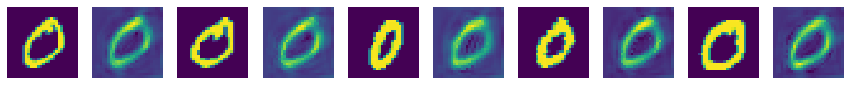

Epoch   0 [  76/  93 (81%)]: loss= 0.359783
Epoch   0 [  77/  93 (82%)]: loss= 0.296429
Epoch   0 [  78/  93 (83%)]: loss= 0.329722
Epoch   0 [  79/  93 (84%)]: loss= 0.316212
Epoch   0 [  80/  93 (86%)]: loss= 0.304472


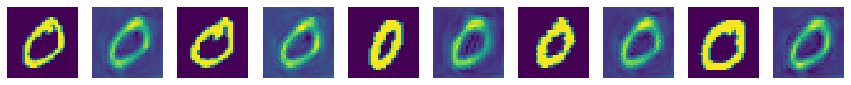

Epoch   0 [  81/  93 (87%)]: loss= 0.321754
Epoch   0 [  82/  93 (88%)]: loss= 0.317284
Epoch   0 [  83/  93 (89%)]: loss= 0.338758
Epoch   0 [  84/  93 (90%)]: loss= 0.380131
Epoch   0 [  85/  93 (91%)]: loss= 0.360310


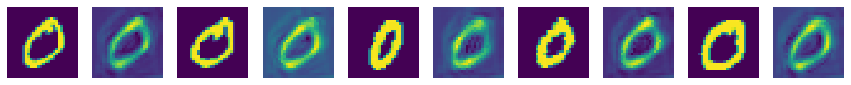

Epoch   0 [  86/  93 (92%)]: loss= 0.364645
Epoch   0 [  87/  93 (93%)]: loss= 0.350298
Epoch   0 [  88/  93 (94%)]: loss= 0.358240
Epoch   0 [  89/  93 (95%)]: loss= 0.337062
Epoch   0 [  90/  93 (96%)]: loss= 0.334344


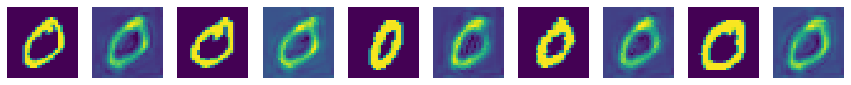

Epoch   0 [  91/  93 (97%)]: loss= 0.365397
Epoch   0 [  92/  93 (98%)]: loss= 0.328221
Epoch   1 [   0/  93 ( 0%)]: loss= 0.360497


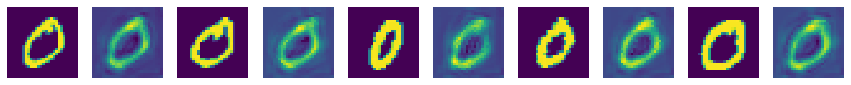

Epoch   1 [   1/  93 ( 1%)]: loss= 0.315595
Epoch   1 [   2/  93 ( 2%)]: loss= 0.410013
Epoch   1 [   3/  93 ( 3%)]: loss= 0.388062
Epoch   1 [   4/  93 ( 4%)]: loss= 0.347983
Epoch   1 [   5/  93 ( 5%)]: loss= 0.377266


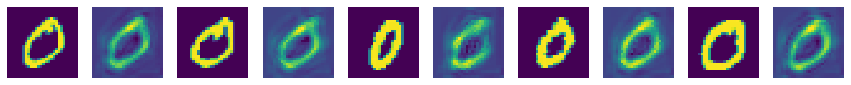

Epoch   1 [   6/  93 ( 6%)]: loss= 0.369111
Epoch   1 [   7/  93 ( 7%)]: loss= 0.342388
Epoch   1 [   8/  93 ( 8%)]: loss= 0.324026
Epoch   1 [   9/  93 ( 9%)]: loss= 0.384346
Epoch   1 [  10/  93 (10%)]: loss= 0.331828


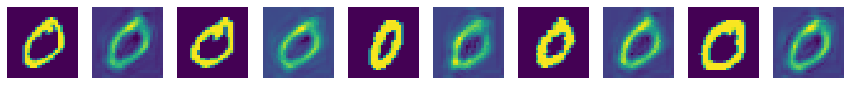

Epoch   1 [  11/  93 (11%)]: loss= 0.382467
Epoch   1 [  12/  93 (12%)]: loss= 0.483387
Epoch   1 [  13/  93 (13%)]: loss= 0.373280
Epoch   1 [  14/  93 (15%)]: loss= 0.473115
Epoch   1 [  15/  93 (16%)]: loss= 0.401027


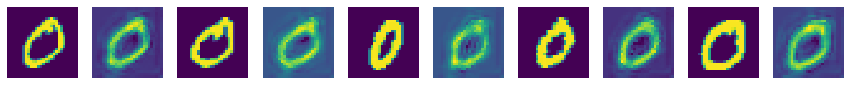

Epoch   1 [  16/  93 (17%)]: loss= 0.384891
Epoch   1 [  17/  93 (18%)]: loss= 0.410808
Epoch   1 [  18/  93 (19%)]: loss= 0.344456
Epoch   1 [  19/  93 (20%)]: loss= 0.431440
Epoch   1 [  20/  93 (21%)]: loss= 0.323926


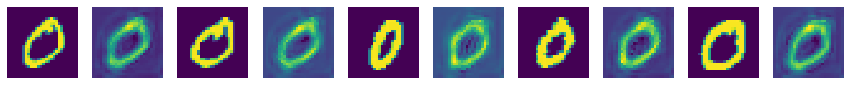

Epoch   1 [  21/  93 (22%)]: loss= 0.363286
Epoch   1 [  22/  93 (23%)]: loss= 0.365832
Epoch   1 [  23/  93 (24%)]: loss= 0.390572
Epoch   1 [  24/  93 (25%)]: loss= 0.370063
Epoch   1 [  25/  93 (26%)]: loss= 0.347720


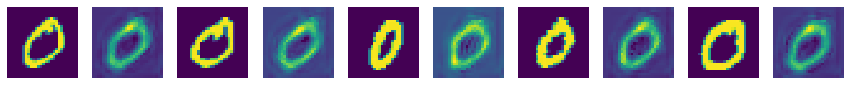

Epoch   1 [  26/  93 (27%)]: loss= 0.342824
Epoch   1 [  27/  93 (29%)]: loss= 0.314165
Epoch   1 [  28/  93 (30%)]: loss= 0.328605
Epoch   1 [  29/  93 (31%)]: loss= 0.313500
Epoch   1 [  30/  93 (32%)]: loss= 0.316046


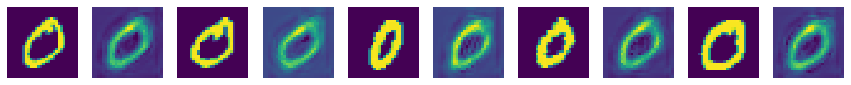

Epoch   1 [  31/  93 (33%)]: loss= 0.313971
Epoch   1 [  32/  93 (34%)]: loss= 0.308734
Epoch   1 [  33/  93 (35%)]: loss= 0.287997
Epoch   1 [  34/  93 (36%)]: loss= 0.298412
Epoch   1 [  35/  93 (37%)]: loss= 0.290130


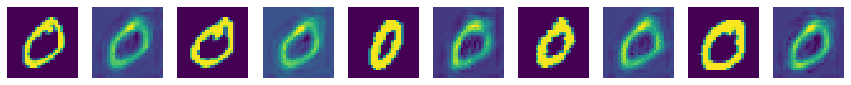

Epoch   1 [  36/  93 (38%)]: loss= 0.303861
Epoch   1 [  37/  93 (39%)]: loss= 0.297556
Epoch   1 [  38/  93 (40%)]: loss= 0.312582
Epoch   1 [  39/  93 (41%)]: loss= 0.292722
Epoch   1 [  40/  93 (43%)]: loss= 0.264933


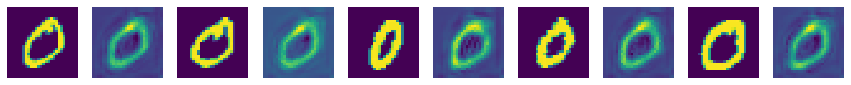

Epoch   1 [  41/  93 (44%)]: loss= 0.265103
Epoch   1 [  42/  93 (45%)]: loss= 0.275090
Epoch   1 [  43/  93 (46%)]: loss= 0.298055
Epoch   1 [  44/  93 (47%)]: loss= 0.269462
Epoch   1 [  45/  93 (48%)]: loss= 0.246162


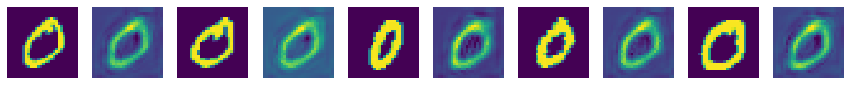

Epoch   1 [  46/  93 (49%)]: loss= 0.270103
Epoch   1 [  47/  93 (50%)]: loss= 0.281556
Epoch   1 [  48/  93 (51%)]: loss= 0.276986
Epoch   1 [  49/  93 (52%)]: loss= 0.280530
Epoch   1 [  50/  93 (53%)]: loss= 0.339129


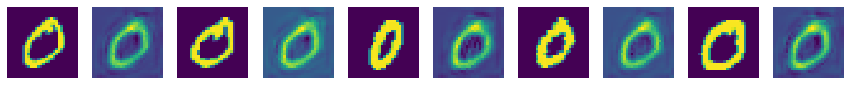

Epoch   1 [  51/  93 (54%)]: loss= 0.341766
Epoch   1 [  52/  93 (55%)]: loss= 0.437552
Epoch   1 [  53/  93 (56%)]: loss= 0.428420
Epoch   1 [  54/  93 (58%)]: loss= 0.544449
Epoch   1 [  55/  93 (59%)]: loss= 0.438595


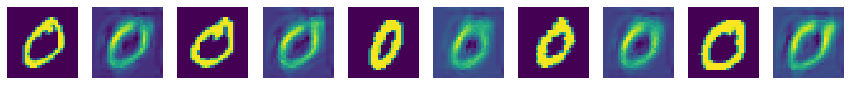

Epoch   1 [  56/  93 (60%)]: loss= 0.567380
Epoch   1 [  57/  93 (61%)]: loss= 0.411592
Epoch   1 [  58/  93 (62%)]: loss= 0.418045
Epoch   1 [  59/  93 (63%)]: loss= 0.512292
Epoch   1 [  60/  93 (64%)]: loss= 0.940910


AssertionError: max_num_steps exceeded (1000>=1000)

In [86]:
train(net)

In [ ]:
train(net_t)

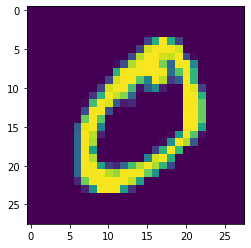

In [110]:
plt.imshow(ideal_digit[0])

In [54]:
def plot_check(NET, NX):
    with torch.no_grad():
        # generate initial point and find trajectory
        OFFSET = 0
        L, R, NT = 0.0, 1.0, 2
        x0 = torch.stack([dmnist[i][0] for i in range(OFFSET, OFFSET+NX)])
        traj = NET.trajectory(x0, L, R, NT).numpy()
        
#     print(np.mean((traj[-1, :, 0, ...] - ideal_digit.repeat(10, 1, 1, 1)[:, 0, ...].numpy())**2))

    NC, SZ = 5, 1.5
    NR = (NX - 1) // (2*NC) + 1
    fig, axes = plt.subplots(nrows=NR, ncols=2*NC, figsize=(2*NC*SZ, NR*SZ))
    axes = axes.flatten()
    axes0 = axes[::2]
    axes1 = axes[1::2]
    for i, ax0, ax1 in zip(range(NX), axes0, axes1):
        logging.render_video(traj[:, i, ...], path='/home/mixs/Documents/research/neuode/dump/digit_%d.mp4'%i)
        ax0.imshow(traj[0, i, 0, ...])
        ax1.imshow(traj[-1, i, 0, ...])
    for ax in axes:
        ax.axis('off')

In [ ]:
plot_check(net, 10)

In [137]:
net.spec.max_num_step = 2000

## MNIST VAE

In [12]:
MODEL_DIR = '/home/mixs/Documents/research/neuode/dump/model'

def get_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)
        print('created directory', path)
    return path

get_dir(MODEL_DIR)

'/home/mixs/Documents/research/neuode/dump/model'

In [9]:
mnist = torchvision.datasets.MNIST(DPATH, train=True, download=True,
        transform=torchvision.transforms.Compose([
            torchvision.transforms.Resize((32, 32)),
            torchvision.transforms.ToTensor(),
            # torchvision.transforms.Normalize((0.1307,), (0.3081,))
    ]))
mnist_loader = torch.utils.data.DataLoader(mnist, batch_size=BATCH_TRAIN_SIZE, shuffle=True)

In [9]:
vae_64 = model_vae.generate_vae(mnist_loader, z_dim=64, nepoch=5, lr=0.1, verbose=True)

Epoch   0 [   0/ 938 ( 0%)]: loss= 8.071019
Epoch   0 [ 100/ 938 (10%)]: loss= 2.272924
Epoch   0 [ 200/ 938 (21%)]: loss= 2.005941
Epoch   0 [ 300/ 938 (31%)]: loss= 1.949553
Epoch   0 [ 400/ 938 (42%)]: loss= 1.829637
Epoch   0 [ 500/ 938 (53%)]: loss= 1.715810
Epoch   0 [ 600/ 938 (63%)]: loss= 1.707373
Epoch   0 [ 700/ 938 (74%)]: loss= 1.633535
Epoch   0 [ 800/ 938 (85%)]: loss= 1.577698
Epoch   0 [ 900/ 938 (95%)]: loss= 1.561122
Epoch   0 [ 937/ 938 (99%)]: loss= 1.631978
Epoch   1 [   0/ 938 ( 0%)]: loss= 1.568402
Epoch   1 [ 100/ 938 (10%)]: loss= 1.653899
Epoch   1 [ 200/ 938 (21%)]: loss= 1.614562
Epoch   1 [ 300/ 938 (31%)]: loss= 1.554567
Epoch   1 [ 400/ 938 (42%)]: loss= 1.703145
Epoch   1 [ 500/ 938 (53%)]: loss= 1.578452
Epoch   1 [ 600/ 938 (63%)]: loss= 1.560894
Epoch   1 [ 700/ 938 (74%)]: loss= 1.529358
Epoch   1 [ 800/ 938 (85%)]: loss= 1.534421
Epoch   1 [ 900/ 938 (95%)]: loss= 1.669329
Epoch   1 [ 937/ 938 (99%)]: loss= 1.588265
Epoch   2 [   0/ 938 ( 0%)]: los

torch.Size([64, 1, 32, 32]) tensor([7, 3, 6, 2, 2, 5, 6, 9, 9, 1, 2, 8, 0, 2, 5, 6, 1, 2, 2, 7, 7, 2, 8, 9,
        4, 4, 3, 2, 7, 0, 0, 3, 9, 7, 3, 0, 8, 7, 3, 7, 4, 5, 2, 4, 1, 9, 1, 6,
        6, 1, 0, 8, 8, 6, 3, 8, 8, 4, 9, 8, 4, 7, 0, 0])


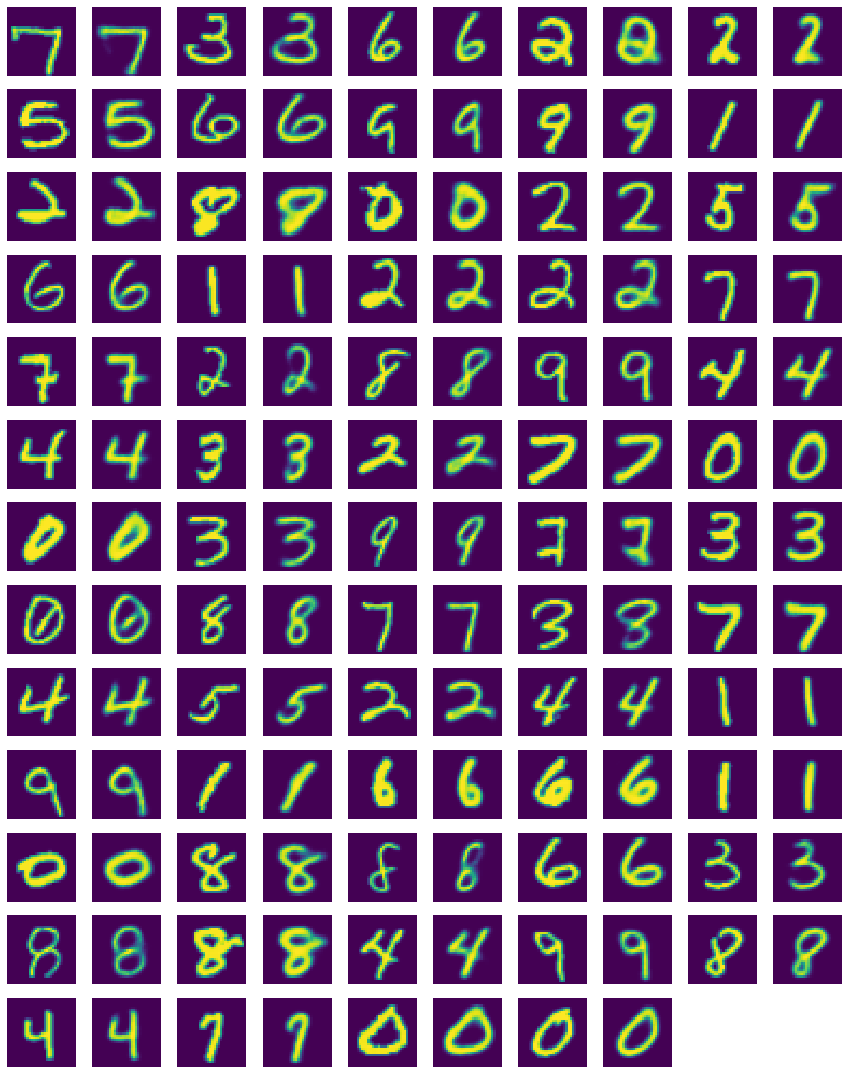

In [14]:
def check_vae(vae):
    with torch.no_grad():
        img, label = next(iter(mnist_loader))
        print(img.shape, label)
        rcnst = vae(img).detach().numpy()

    NX = 64  # <= 64
    NC, SZ = 5, 1.5
    NR = (NX - 1) // NC + 1
    fig, axes = plt.subplots(nrows=NR, ncols=2*NC, figsize=(2*NC*SZ, NR*SZ))
    axes = axes.flatten()
    axes0 = axes[::2]
    axes1 = axes[1::2]
    for i, ax0, ax1 in zip(range(NX), axes0, axes1):
        ax0.imshow(img[i, 0, ...])
        ax1.imshow(rcnst[i, 0, ...])
    for ax in axes:
        ax.axis('off')
    plt.show()

check_vae(vae_64)

In [13]:
IS_SAVE = False
p = os.path.join(MODEL_DIR, 'mnist_vae_64.pth')

if IS_SAVE:
    model_vae.save_vae(vae_64, p)
else:
    vae_64 = model_vae.build_vae(model_vae.build_spec_from_loader(mnist_loader, 64), p)

### Train NeuODE

In [ ]:
# principle digit (mean)
ideal_digits = []
for dm in dmnist:
    ideal_digits.append(dm[0][0])
ideal_digits = torch.stack(ideal_digits, 0)

with torch.no_grad():
    ideal_mu, _ = vae_64.nets[0](ideal_digits)

print('digit shape:', ideal_digit.shape)
print('mu shape:', ideal_mu.shape)
print('mu checksum:', torch.sum(ideal_mu.reshape(10, -1), axis=1))

[autoreload of neuode.function.linear failed: Traceback (most recent call last):
  File "/home/mixs/anaconda3/envs/mseg/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/home/mixs/anaconda3/envs/mseg/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 450, in superreload
    update_generic(old_obj, new_obj)
  File "/home/mixs/anaconda3/envs/mseg/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 387, in update_generic
    update(a, b)
  File "/home/mixs/anaconda3/envs/mseg/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 357, in update_class
    update_instances(old, new)
  File "/home/mixs/anaconda3/envs/mseg/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 312, in update_instances
    update_instances(old, new, obj.__dict__, visited)
  File "/home/mixs/anaconda3/envs/mseg/lib/python3.7/site-packages/IPython/extensions/autoreload.

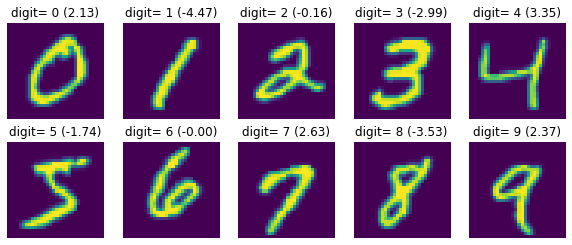

In [93]:
def pick_digits(labels):
    digits = torch.zeros((len(labels),) + ideal_digits.shape[1:])
    for i, l in enumerate(labels):
        digits[i, ...] = ideal_digits[l, ...]
    return digits

def pick_mu(labels):
    mus = torch.zeros((len(labels),) + ideal_mu.shape[1:])
    for i, l in enumerate(labels):
        mus[i, ...] = ideal_mu[l, ...]
    return mus

def plot_labels(labels):
    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 4)); axes = axes.flatten()
    dplots = pick_digits(labels)
    mcheck = pick_mu(labels)
    for i, ax in zip(range(len(labels)), axes):
        ax.imshow(dplots[i, 0, ...])
        ax.set_title('digit= %d (%.2f)'%(labels[i], torch.sum(mcheck[i])))
    for ax in axes:
        ax.axis('off')

plot_labels(list(range(10)))

In [81]:
# build model
lfn_specs = [
    LinearSpec(64, 128, ActivationFn.RELU),
    LinearSpec(128, 64, ActivationFn.NONE),
]
lode_spec = ODEBlockSpec(use_adjoint=True)
lfn = linear.MLPDMap(lfn_specs)
lnet = odeblock.ODEBlock(lfn, lode_spec)

In [88]:
# train
def train_l(loader, target_mu, vae, net):
    lr, momentum = 0.01, 0.9
    net.train()
    vae.eval()
    for epoch in range(10):
        criterion = nn.MSELoss()
        optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum)
        total = len(loader)
        for batch_idx, (data, labels) in enumerate(loader):
            optimizer.zero_grad()
            enc, _ = vae.nets[0](data)
            pred = net(enc)
            loss = criterion(pred, pick_mu(labels))
            loss.backward()
            optimizer.step()
            if batch_idx%10 == 0 or batch_idx == total-1:
                print('Epoch %3d [%4d/%4d (%2d%%)]: loss= %f'%(
                    epoch, batch_idx, total, int(100 * batch_idx / total), loss.item()))

In [89]:
train_l(mnist_loader, ideal_mu, vae_64, lnet)

Epoch   0 [   0/ 938 ( 0%)]: loss= 0.161058
Epoch   0 [  10/ 938 ( 1%)]: loss= 0.185037
Epoch   0 [  20/ 938 ( 2%)]: loss= 0.185524
Epoch   0 [  30/ 938 ( 3%)]: loss= 0.188061
Epoch   0 [  40/ 938 ( 4%)]: loss= 0.184877
Epoch   0 [  50/ 938 ( 5%)]: loss= 0.176062
Epoch   0 [  60/ 938 ( 6%)]: loss= 0.159593
Epoch   0 [  70/ 938 ( 7%)]: loss= 0.158682
Epoch   0 [  80/ 938 ( 8%)]: loss= 0.183561
Epoch   0 [  90/ 938 ( 9%)]: loss= 0.146822
Epoch   0 [ 100/ 938 (10%)]: loss= 0.158334
Epoch   0 [ 110/ 938 (11%)]: loss= 0.155758
Epoch   0 [ 120/ 938 (12%)]: loss= 0.156234
Epoch   0 [ 130/ 938 (13%)]: loss= 0.155919
Epoch   0 [ 140/ 938 (14%)]: loss= 0.152593
Epoch   0 [ 150/ 938 (15%)]: loss= 0.155254
Epoch   0 [ 160/ 938 (17%)]: loss= 0.159096
Epoch   0 [ 170/ 938 (18%)]: loss= 0.156315
Epoch   0 [ 180/ 938 (19%)]: loss= 0.134645
Epoch   0 [ 190/ 938 (20%)]: loss= 0.153181
Epoch   0 [ 200/ 938 (21%)]: loss= 0.142212
Epoch   0 [ 210/ 938 (22%)]: loss= 0.176903
Epoch   0 [ 220/ 938 (23%)]: los

Epoch   1 [ 920/ 938 (98%)]: loss= 0.084004
Epoch   1 [ 930/ 938 (99%)]: loss= 0.072116
Epoch   1 [ 937/ 938 (99%)]: loss= 0.074933
Epoch   2 [   0/ 938 ( 0%)]: loss= 0.075530
Epoch   2 [  10/ 938 ( 1%)]: loss= 0.076548
Epoch   2 [  20/ 938 ( 2%)]: loss= 0.079993
Epoch   2 [  30/ 938 ( 3%)]: loss= 0.072787
Epoch   2 [  40/ 938 ( 4%)]: loss= 0.076614
Epoch   2 [  50/ 938 ( 5%)]: loss= 0.077280
Epoch   2 [  60/ 938 ( 6%)]: loss= 0.073355
Epoch   2 [  70/ 938 ( 7%)]: loss= 0.080863
Epoch   2 [  80/ 938 ( 8%)]: loss= 0.087386
Epoch   2 [  90/ 938 ( 9%)]: loss= 0.084858
Epoch   2 [ 100/ 938 (10%)]: loss= 0.084735
Epoch   2 [ 110/ 938 (11%)]: loss= 0.076141
Epoch   2 [ 120/ 938 (12%)]: loss= 0.073670
Epoch   2 [ 130/ 938 (13%)]: loss= 0.075056
Epoch   2 [ 140/ 938 (14%)]: loss= 0.081426
Epoch   2 [ 150/ 938 (15%)]: loss= 0.070063
Epoch   2 [ 160/ 938 (17%)]: loss= 0.084773
Epoch   2 [ 170/ 938 (18%)]: loss= 0.076995
Epoch   2 [ 180/ 938 (19%)]: loss= 0.079521
Epoch   2 [ 190/ 938 (20%)]: los

Epoch   3 [ 890/ 938 (94%)]: loss= 0.052054
Epoch   3 [ 900/ 938 (95%)]: loss= 0.065554
Epoch   3 [ 910/ 938 (97%)]: loss= 0.057441
Epoch   3 [ 920/ 938 (98%)]: loss= 0.062349
Epoch   3 [ 930/ 938 (99%)]: loss= 0.058806
Epoch   3 [ 937/ 938 (99%)]: loss= 0.052092
Epoch   4 [   0/ 938 ( 0%)]: loss= 0.058878
Epoch   4 [  10/ 938 ( 1%)]: loss= 0.066261
Epoch   4 [  20/ 938 ( 2%)]: loss= 0.069954
Epoch   4 [  30/ 938 ( 3%)]: loss= 0.051587
Epoch   4 [  40/ 938 ( 4%)]: loss= 0.050781
Epoch   4 [  50/ 938 ( 5%)]: loss= 0.055605
Epoch   4 [  60/ 938 ( 6%)]: loss= 0.063553
Epoch   4 [  70/ 938 ( 7%)]: loss= 0.056507
Epoch   4 [  80/ 938 ( 8%)]: loss= 0.053447
Epoch   4 [  90/ 938 ( 9%)]: loss= 0.055991
Epoch   4 [ 100/ 938 (10%)]: loss= 0.054801
Epoch   4 [ 110/ 938 (11%)]: loss= 0.054853
Epoch   4 [ 120/ 938 (12%)]: loss= 0.062455
Epoch   4 [ 130/ 938 (13%)]: loss= 0.047602
Epoch   4 [ 140/ 938 (14%)]: loss= 0.054619
Epoch   4 [ 150/ 938 (15%)]: loss= 0.057158
Epoch   4 [ 160/ 938 (17%)]: los

Epoch   5 [ 860/ 938 (91%)]: loss= 0.046201
Epoch   5 [ 870/ 938 (92%)]: loss= 0.050031
Epoch   5 [ 880/ 938 (93%)]: loss= 0.053051
Epoch   5 [ 890/ 938 (94%)]: loss= 0.056119
Epoch   5 [ 900/ 938 (95%)]: loss= 0.041860
Epoch   5 [ 910/ 938 (97%)]: loss= 0.050082
Epoch   5 [ 920/ 938 (98%)]: loss= 0.039029
Epoch   5 [ 930/ 938 (99%)]: loss= 0.045217
Epoch   5 [ 937/ 938 (99%)]: loss= 0.045421
Epoch   6 [   0/ 938 ( 0%)]: loss= 0.052435
Epoch   6 [  10/ 938 ( 1%)]: loss= 0.046092
Epoch   6 [  20/ 938 ( 2%)]: loss= 0.046131
Epoch   6 [  30/ 938 ( 3%)]: loss= 0.048432
Epoch   6 [  40/ 938 ( 4%)]: loss= 0.039571
Epoch   6 [  50/ 938 ( 5%)]: loss= 0.037875
Epoch   6 [  60/ 938 ( 6%)]: loss= 0.047656
Epoch   6 [  70/ 938 ( 7%)]: loss= 0.046745
Epoch   6 [  80/ 938 ( 8%)]: loss= 0.048229
Epoch   6 [  90/ 938 ( 9%)]: loss= 0.052611
Epoch   6 [ 100/ 938 (10%)]: loss= 0.043686
Epoch   6 [ 110/ 938 (11%)]: loss= 0.046361
Epoch   6 [ 120/ 938 (12%)]: loss= 0.043239
Epoch   6 [ 130/ 938 (13%)]: los

Epoch   7 [ 830/ 938 (88%)]: loss= 0.038330
Epoch   7 [ 840/ 938 (89%)]: loss= 0.041608
Epoch   7 [ 850/ 938 (90%)]: loss= 0.041962
Epoch   7 [ 860/ 938 (91%)]: loss= 0.040746
Epoch   7 [ 870/ 938 (92%)]: loss= 0.038685
Epoch   7 [ 880/ 938 (93%)]: loss= 0.040513
Epoch   7 [ 890/ 938 (94%)]: loss= 0.041120
Epoch   7 [ 900/ 938 (95%)]: loss= 0.031319
Epoch   7 [ 910/ 938 (97%)]: loss= 0.031847
Epoch   7 [ 920/ 938 (98%)]: loss= 0.044607
Epoch   7 [ 930/ 938 (99%)]: loss= 0.043971
Epoch   7 [ 937/ 938 (99%)]: loss= 0.033724
Epoch   8 [   0/ 938 ( 0%)]: loss= 0.036035
Epoch   8 [  10/ 938 ( 1%)]: loss= 0.039937
Epoch   8 [  20/ 938 ( 2%)]: loss= 0.046829
Epoch   8 [  30/ 938 ( 3%)]: loss= 0.037419
Epoch   8 [  40/ 938 ( 4%)]: loss= 0.041427
Epoch   8 [  50/ 938 ( 5%)]: loss= 0.038006
Epoch   8 [  60/ 938 ( 6%)]: loss= 0.051213
Epoch   8 [  70/ 938 ( 7%)]: loss= 0.039618
Epoch   8 [  80/ 938 ( 8%)]: loss= 0.043315
Epoch   8 [  90/ 938 ( 9%)]: loss= 0.039725
Epoch   8 [ 100/ 938 (10%)]: los

Epoch   9 [ 800/ 938 (85%)]: loss= 0.032913
Epoch   9 [ 810/ 938 (86%)]: loss= 0.036159
Epoch   9 [ 820/ 938 (87%)]: loss= 0.036202
Epoch   9 [ 830/ 938 (88%)]: loss= 0.029323
Epoch   9 [ 840/ 938 (89%)]: loss= 0.038878
Epoch   9 [ 850/ 938 (90%)]: loss= 0.027689
Epoch   9 [ 860/ 938 (91%)]: loss= 0.027645
Epoch   9 [ 870/ 938 (92%)]: loss= 0.035737
Epoch   9 [ 880/ 938 (93%)]: loss= 0.034160
Epoch   9 [ 890/ 938 (94%)]: loss= 0.037142
Epoch   9 [ 900/ 938 (95%)]: loss= 0.030717
Epoch   9 [ 910/ 938 (97%)]: loss= 0.031352
Epoch   9 [ 920/ 938 (98%)]: loss= 0.032261
Epoch   9 [ 930/ 938 (99%)]: loss= 0.028307
Epoch   9 [ 937/ 938 (99%)]: loss= 0.028922


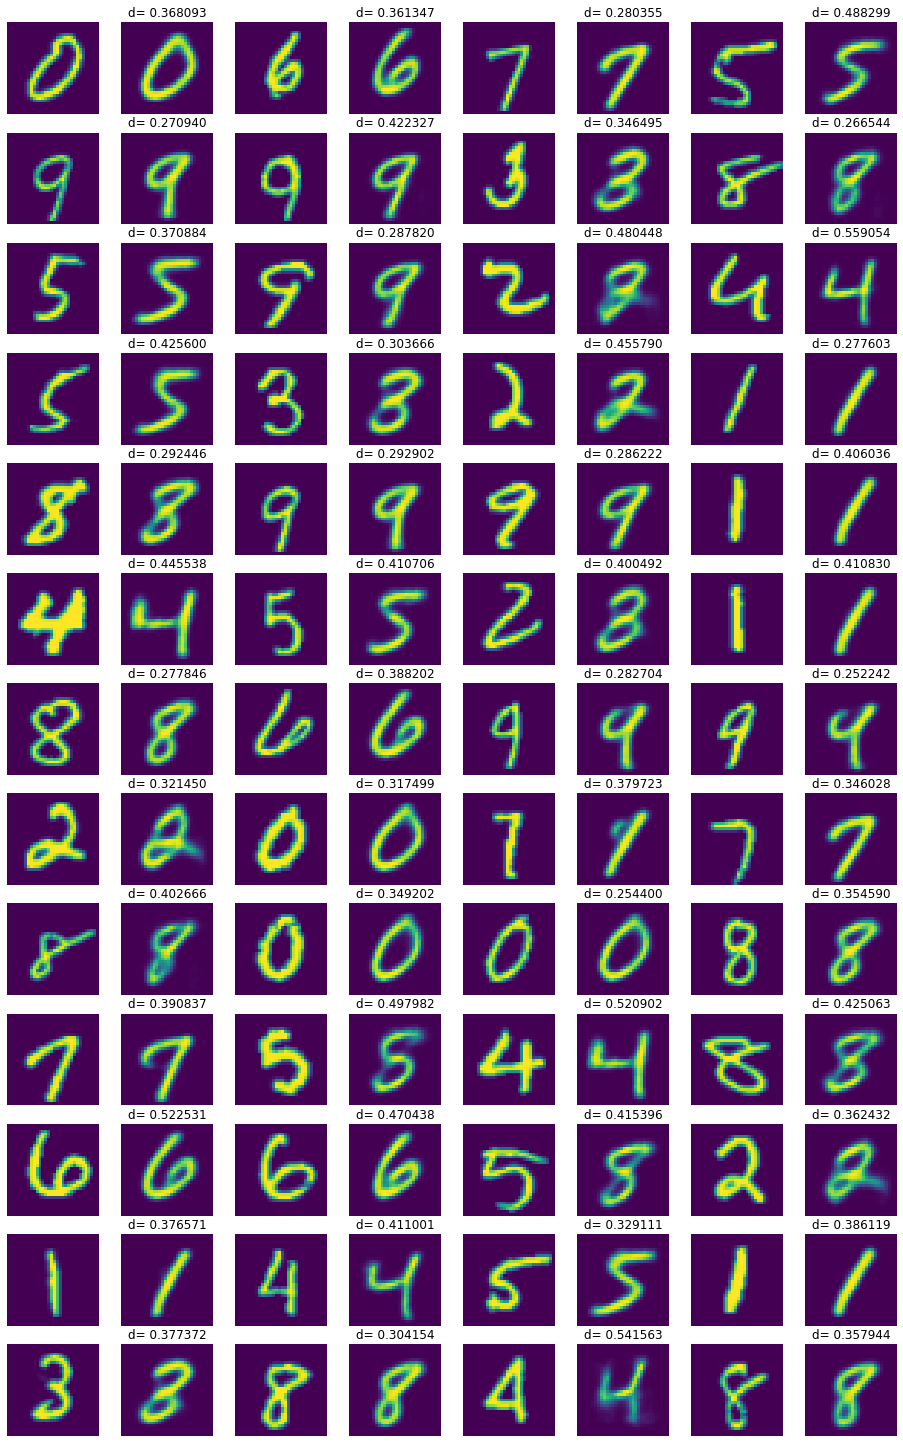

In [112]:
def plot_check_vae(NET, VAE, NX):
    with torch.no_grad():
        # generate initial point and find trajectory
        x0 = next(iter(mnist_loader))[0][:NX]
        z0, _ = VAE.nets[0](x0)
        traj = VAE.nets[1](NET(z0))

    NC, SZ = 4, 2
    NR = (NX - 1) // (2*NC) + 1
    fig, axes = plt.subplots(nrows=NR, ncols=2*NC, figsize=(2*NC*SZ, NR*SZ))
    axes = axes.flatten()
    axes0 = axes[::2]
    axes1 = axes[1::2]
    for i, ax0, ax1 in zip(range(NX), axes0, axes1):
        ax0.imshow(x0[i, 0, ...])
        ax1.imshow(traj[i, 0, ...])
        ax1.set_title('d= %f'%(torch.mean((z0[i] - ideal_mu)**2).item()))
    for ax in axes:
        ax.axis('off')
        
plot_check_vae(lnet, vae_64, 100)

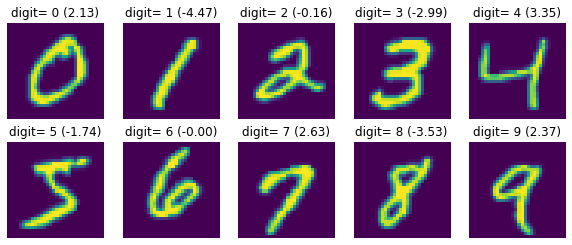

In [94]:
plot_labels(list(range(10)))

In [110]:
def plot_check_traj_vae(NET, VAE, NX, OFFSET, TR=2.0):
    with torch.no_grad():
        # generate initial point and find trajectory
        L, R, NT = 0.0, 1.0, 2
        x0 = torch.stack([mnist[OFFSET][0]])
        z0, _ = VAE.nets[0](x0)
        traj = VAE.nets[1](NET.trajectory(z0, 0.0, TR, NX)[:, 0, ...])

    NC, SZ = 8, 2
    NR = (NX - 1) // NC + 1
    fig, axes = plt.subplots(nrows=NR, ncols=NC, figsize=(NC*SZ, NR*SZ))
    axes = axes.flatten()
    for i, ax, t in zip(range(NX), axes, np.linspace(0.0, TR, NX)):
        ax.imshow(traj[i, 0, ...])
        ax.set_title('t= %f'%t)
    for ax in axes:
        ax.axis('off')

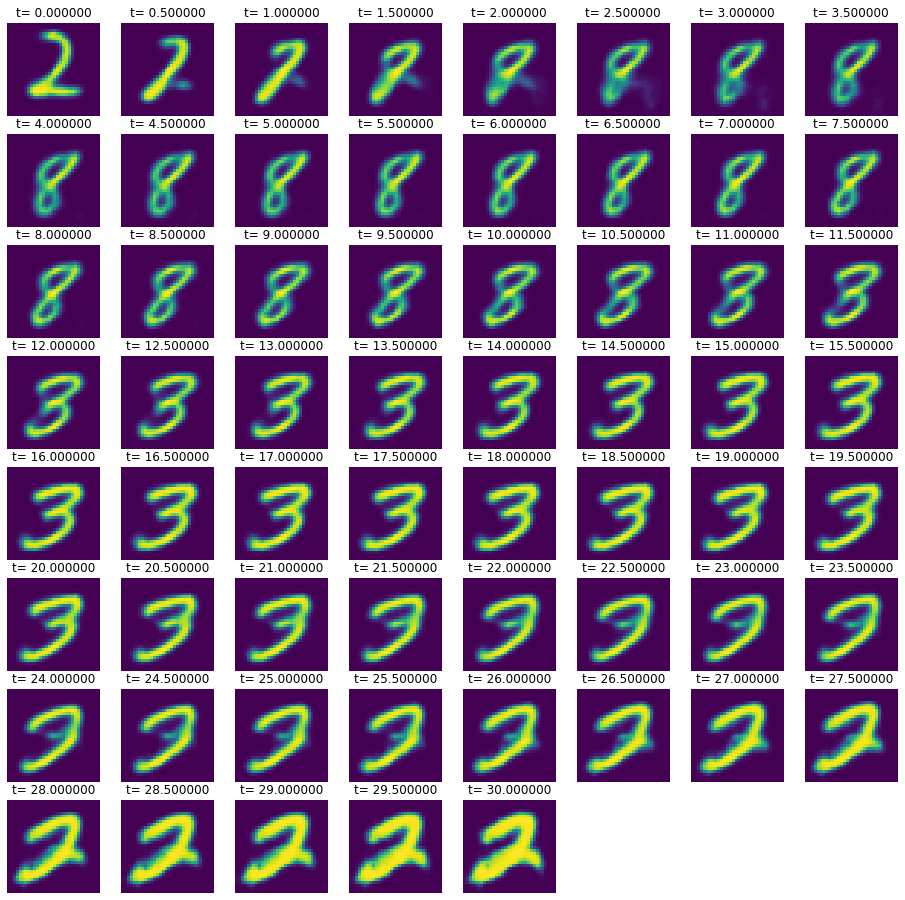

In [111]:
TR = 30
MUL = 2
plot_check_traj_vae(lnet, vae_64, TR*MUL+1, 122, TR=TR)

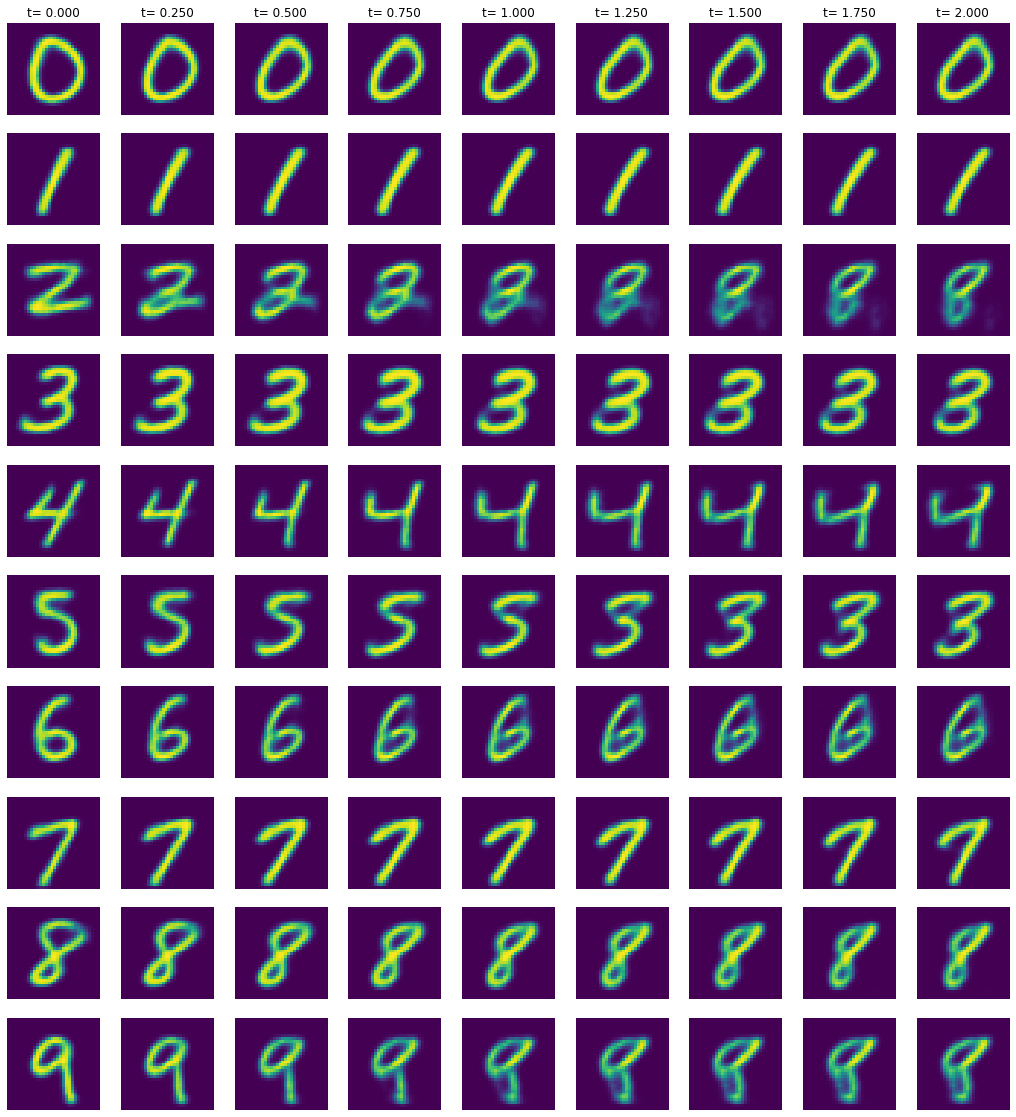

In [147]:
def plot_check_traj_vae_multiple(NET, VAE, NR, NC, TR=2.0):
    with torch.no_grad():
#         x0 = next(iter(mnist_loader))[0][:NR]
        x0 = torch.stack([dm[11][0] for dm in dmnist])
        z0, _ = VAE.nets[0](x0)
        traj = NET.trajectory(z0, 0.0, TR, NC)
        
    SZ = 2.0
    fig, axes = plt.subplots(nrows=NR, ncols=NC, figsize=(NC*SZ, NR*SZ))
    for i, axs in zip(range(NR), axes):
        img_traj = VAE.nets[1](traj[:, i, ...]).detach().numpy()
        for j, ax, t in zip(range(NC), axs, np.linspace(0.0, TR, NC)):
            ax.imshow(img_traj[j, 0, ...])
            if i == 0:
                ax.set_title('t= %.3f'%t)
    for ax in axes.flatten():
        ax.axis('off')
        
plot_check_traj_vae_multiple(lnet, vae_64, 10, 9, TR=2.0)